Программа получает на вход файлы из папки, в которых содержатся данные для построения графиков, отрисовывает каждый график и по надобности сохраняет его. Дополнительно увеличение по временному масштабу 100 нс, 1 мкс, 10 мкс.  
_______
**Названия рисунков**  
AAA.A_CCC_D_E_10us.png 
AAA.A – Толщина образца и порядковый номер (400.1)  
BBBBBB – День эксперимента  - день месяц год(060924)  
CCC – Номер эксперимента (001)  
D – Количество импульсов(1)  
E – Энергия в импульсе нДж (5)  
F - Увеличение(10us)  
____
**Пример** получившегося названия:  
400.1.060924.001.1.5.png

#### Задачи:
- Доступ к общей таблице
- Увеличение графиков
- Название файлов
- Перевод в Вт
- Начало с какого файла
- Обрабатывать новые файлы в режиме реального времени
- Производить увеличение второго графика спустя задержку ~80нс плюс отступ назад 5нс, и от этой точки взять 100 нс, 1 мкс или 10 мкс

In [ ]:
!pip install pandas matplotlib openpyxl scipy

103385
Tek090_ALL.csv


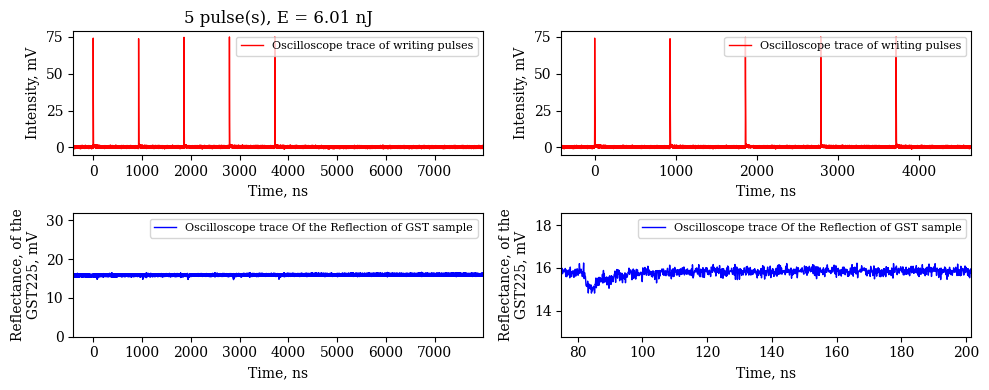

shot11.csv


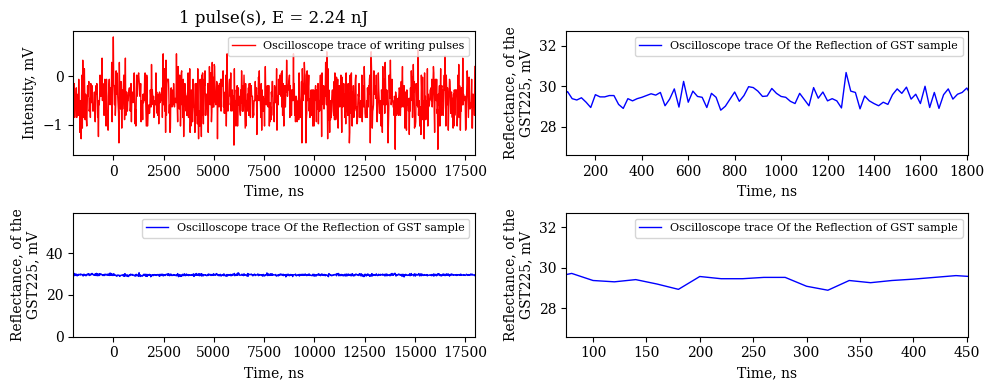

shot12.csv


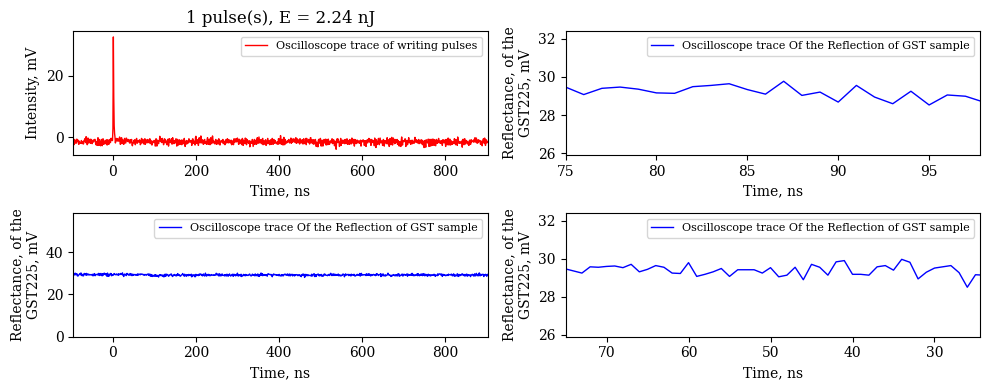

shot13.csv


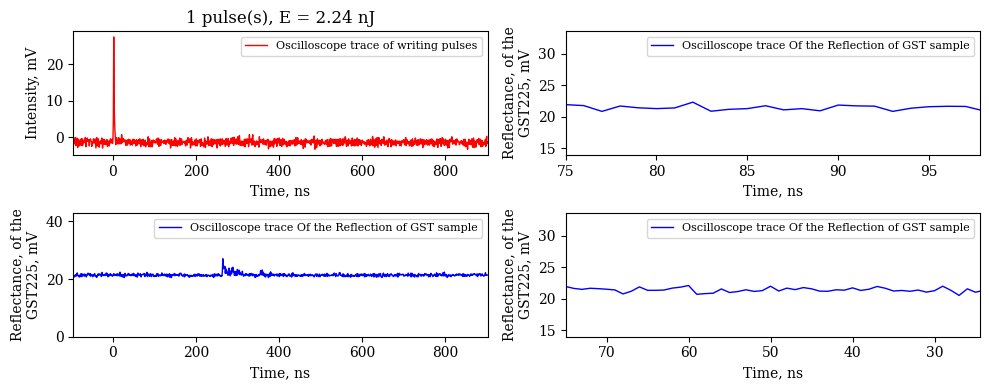

568
shot14.csv


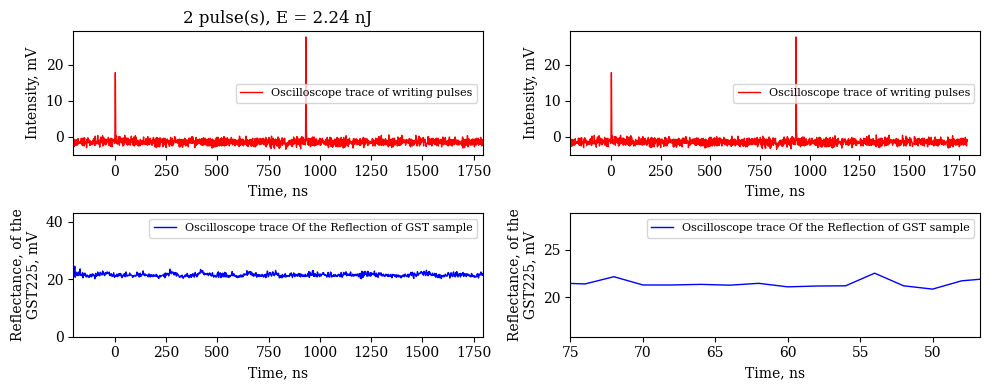

568
shot15.csv


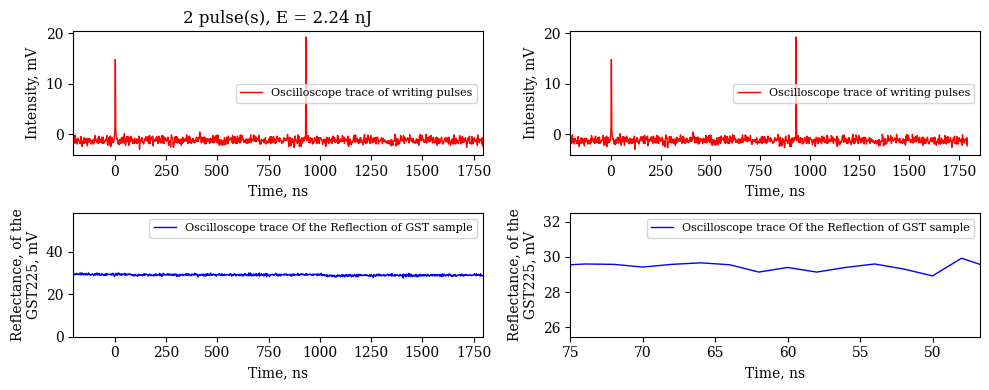

shot16.csv


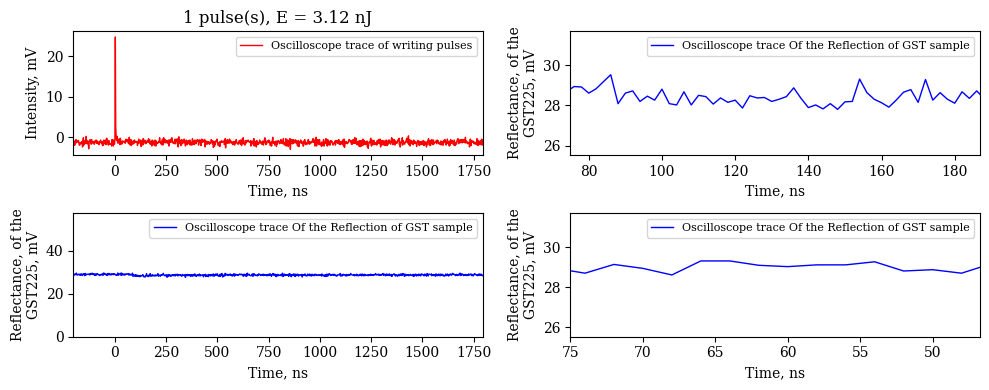

shot17.csv


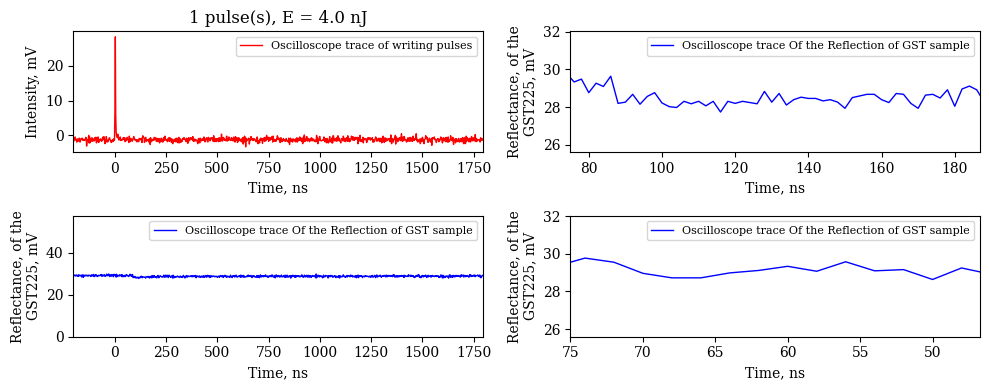

shot18.csv


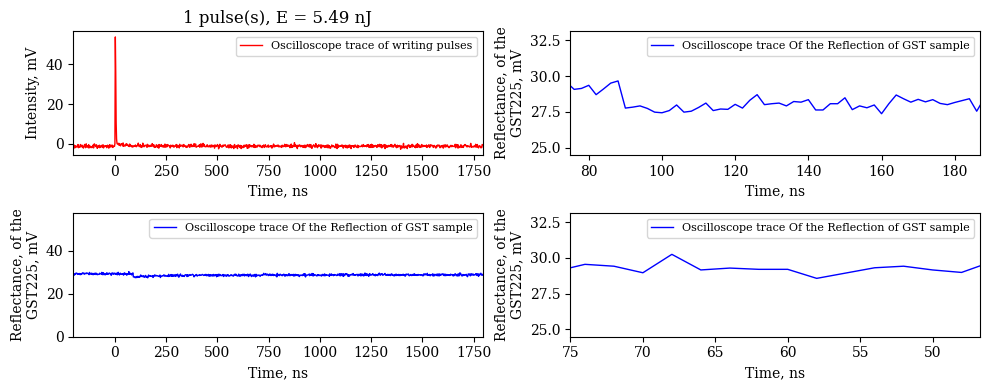

515
shot19.csv


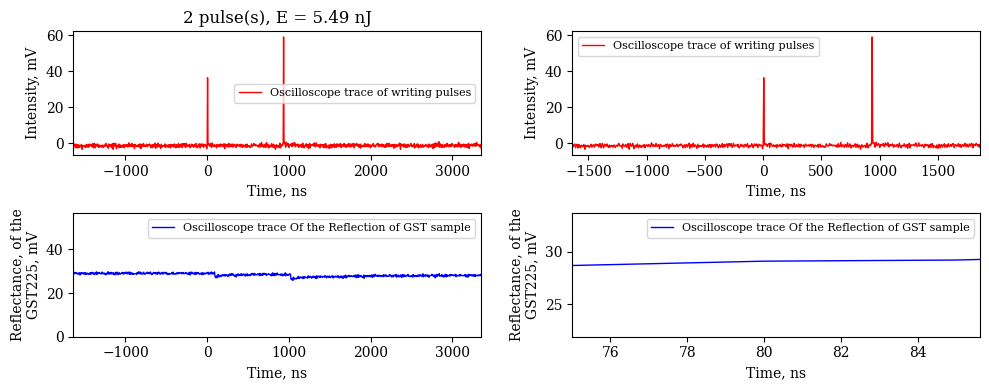

701
shot20.csv


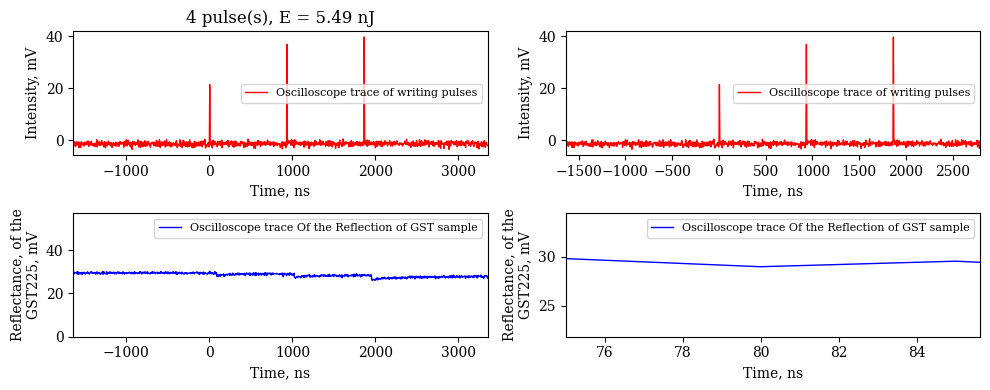

663
shot21.csv


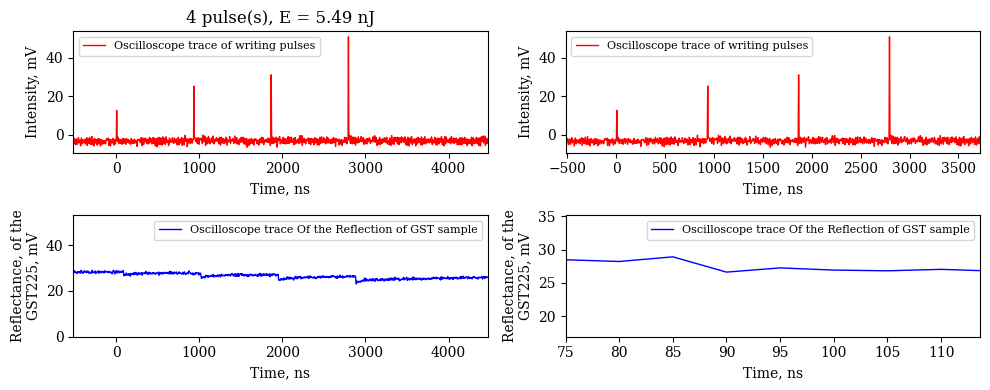

663
shot22.csv


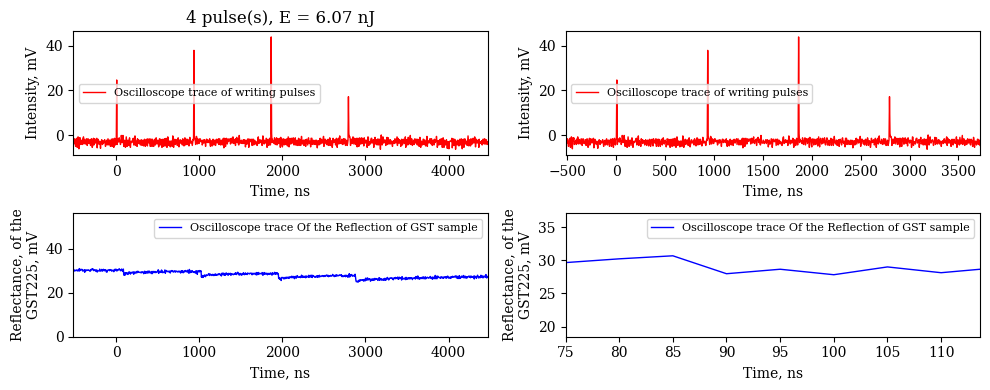

663
shot23.csv


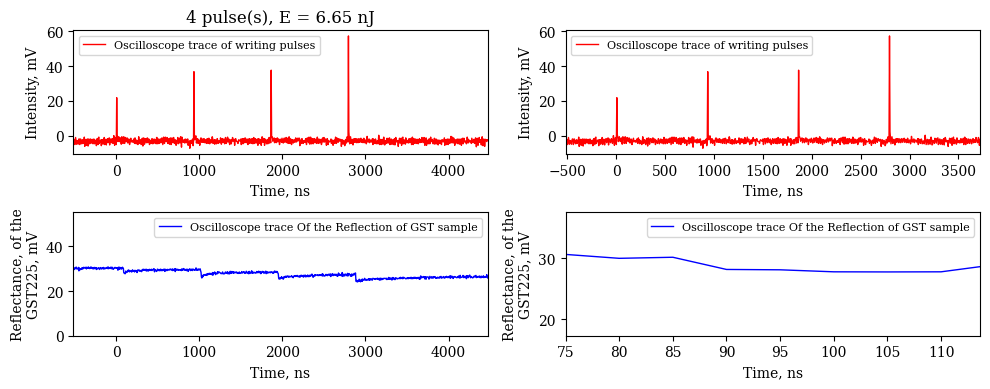

663
shot24.csv


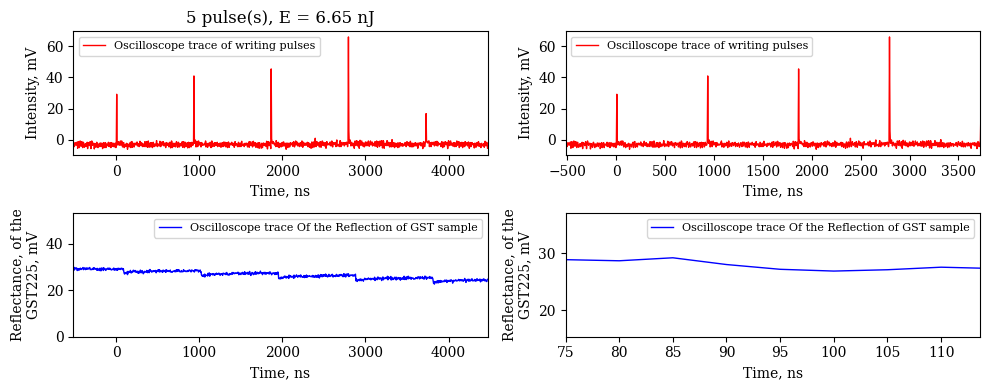

657
shot25.csv


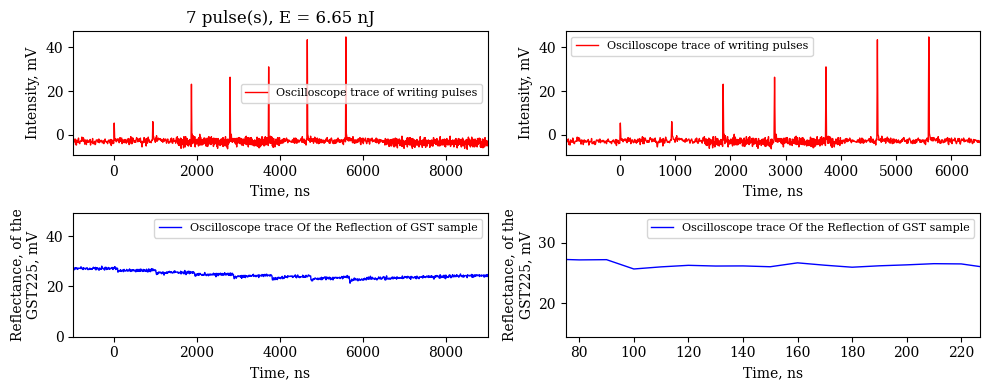

750
shot26.csv


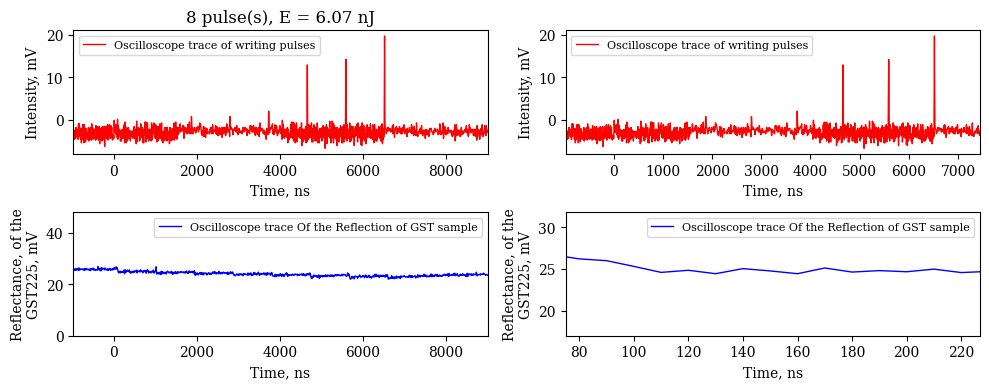

363
shot27.csv


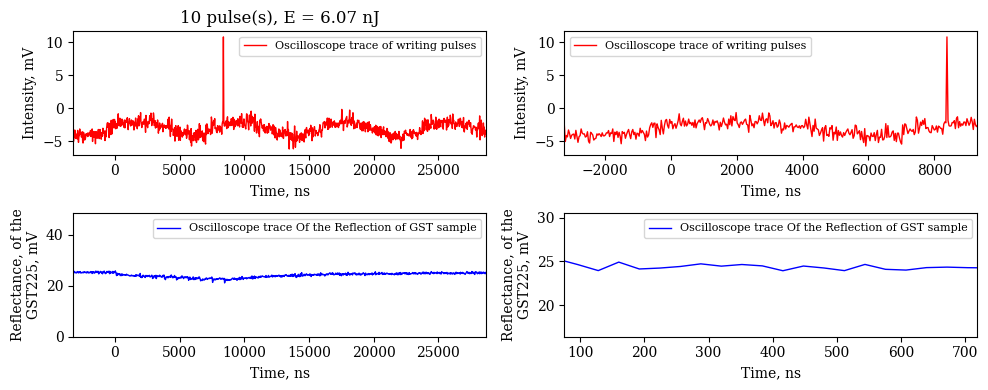

392
shot28.csv


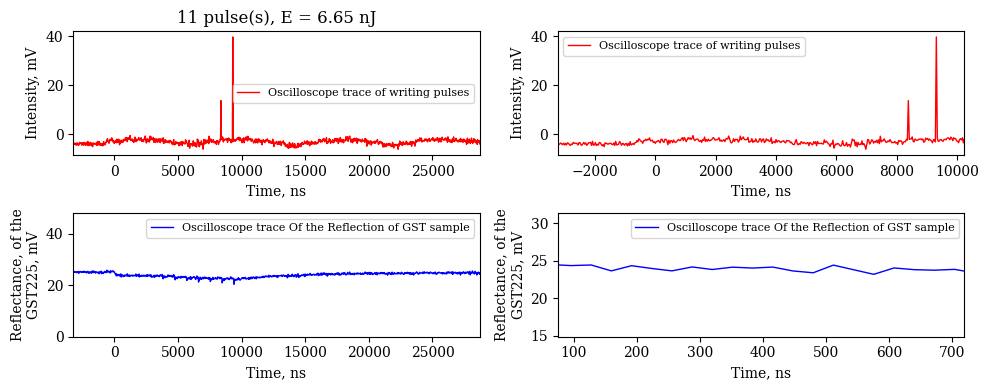

363
shot29.csv


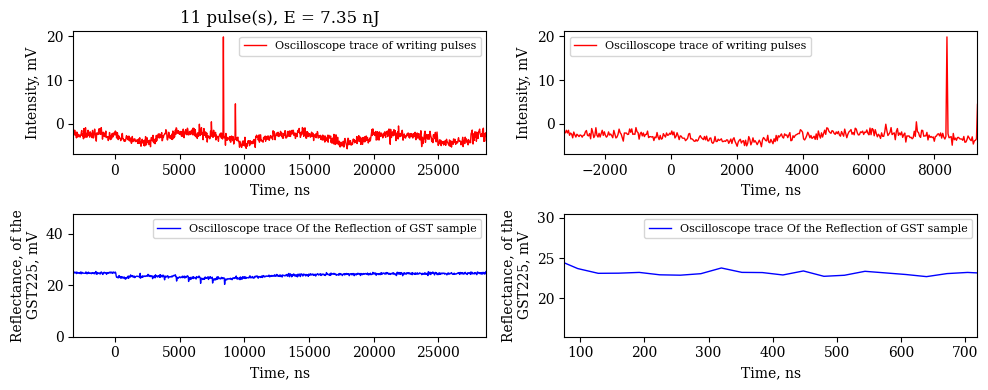

IndexError: index -1 is out of bounds for axis 0 with size 0

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import numpy as np
from scipy.signal import find_peaks 

start_file = None
# start_file = 'shot18.csv' # Rigol
# start_file = 'Tek004_ALL.csv' # Tektronix

# dir = 'waveforms/110924/' # папка с осциллограммами
dir = 'waveforms/060924/Осциллограммы переходов/' # папка с осциллограммами
general_file = 'waveforms/060924/General.xlsx'
files = sorted(os.listdir(dir))

csv_files_all = [file for file in files if (file.endswith('.csv'))]
csv_files = [file for file in csv_files_all if (file.startswith('shot') or file.startswith('Tek'))]

df_gen = pd.read_excel(general_file)
col_index = df_gen.columns.get_loc('Общая энергия, нДж')
df_gen = df_gen.iloc[:, :col_index+1]

def plot_graph(x, y, color_, label_, ylabel, xlabel, xlim1, xlim2, increase):
    plt.xlim(xlim1, xlim2/increase)
    plt.ylabel(ylabel, fontsize=10)
    plt.xlabel(xlabel, fontsize=10)
    plt.plot(df[x]*1e9, df[y]*1e3, color=color_, linewidth=1,
             label=label_)
    plt.legend(fontsize=8)


def plot_graphics(pulses, energy, flag_pulse, peak):
    plt.figure(figsize=(10, 4))
    plt.rcParams["font.family"] = "serif" # font

    # 1) Без увеличения
    plt.subplot(2, 2, 1)
    plot_graph(x='TIME', y='CH1', color_='red', 
        label_='Oscilloscope trace of writing pulses', 
        ylabel='Intensity, mV', xlabel='Time, ns', 
        xlim1=df.iloc[0, 0]*1e9, xlim2=df.iloc[-1, 0]*1e9, increase=1)
    plt.title(label= f'{pulses} pulse(s), E = {energy} nJ')


    plt.subplot(2, 2, 3)
    plot_graph(x='TIME', y='CH2', color_='blue', 
        label_='Oscilloscope trace Of the Reflection of GST sample', 
        ylabel=r'Reflectance, of the' + '\n' +'GST225, mV', xlabel='Time, ns', 
        xlim1=df.iloc[0, 0]*1e9, xlim2=df.iloc[-1, 0]*1e9, increase=1)
    plt.ylim(0, y_avg*1e3*2)


    # 2) Увеличение
    plt.subplot(2, 2, 2)
    if (flag_pulse=='one'):
        plot_graph(x='TIME', y='CH2', color_='blue', 
            label_='Oscilloscope trace Of the Reflection of GST sample', 
            ylabel=r'Reflectance, of the' + '\n' +'GST225, mV', xlabel='Time, ns', 
            xlim1=75, xlim2=75+df.iloc[-1, 0]*1e9, increase=10)
        plt.ylim(y_start*1e3, y_end*1e3)
        
    else:
        plot_graph(x='TIME', y='CH1', color_='red', 
            label_='Oscilloscope trace of writing pulses', 
            ylabel='Intensity, mV', xlabel='Time, ns', 
            xlim1=df.iloc[0, 0]*1e9, xlim2=(df.iloc[peak, 0]*1e9+926), increase=1)


    # 3) Увеливение
    plt.subplot(2, 2, 4)
    plot_graph(x='TIME', y='CH2', color_='blue', 
        label_='Oscilloscope trace Of the Reflection of GST sample', 
        ylabel=r'Reflectance, of the' + '\n' +'GST225, mV', xlabel='Time, ns', 
        xlim1=75, xlim2=75+df.iloc[-1, 0]*1e9, increase=40)
    plt.ylim(y_start*1e3, y_end*1e3)

    plt.tight_layout()  # Автоматическая регулировка расстояния между графиками
    

# Узнаем номер снимка
def osc_number(file):
    if ('Tek' in file):
        exp_number = file.replace('Tek', '')
        exp_number = exp_number.replace('_ALL.csv', '')
    else:
        exp_number = file.replace('shot', '')
        exp_number = exp_number.replace('.csv', '')

    return int(exp_number)


def last_peak(df):
    min_height = df['CH1'].max() / 3
    indexes, properties = find_peaks(df['CH1'], height=min_height)
    last_peak_index = indexes[-1]
    print(last_peak_index)
    return last_peak_index


start_index = csv_files.index(start_file) if start_file is not None else 0
for file in csv_files[start_index:]:
    path = dir + file

    # Для пропуска любой "Шапки" файла
    f = open(path, 'r')
    lines = f.readlines()
    skip_lines = next(i for i, line in enumerate(lines) 
                  if 'TIME' in line or 'Time(s)' in line)
    f.close()

    # Номер эксперимента, кол-во импульсов, энергия
    num = osc_number(file)
    pulses = df_gen.loc[df_gen['Shot'] == num, 'Количество'].iloc[0]
    energy = round(df_gen.loc[df_gen['Shot'] == num, 
                              'Энергия, нДж'].iloc[0], 2)
    
    flag_pulse = 'many' if pulses > 1 else 'one' 
    

    column_names = ['TIME', 'CH1', 'CH2', 'CH3']
    df = pd.read_csv(path, skiprows=skip_lines+1, header=None, names=column_names)
    df = df.drop('CH3', axis=1)
    df.replace(np.inf, np.nan, inplace=True) # Если есть значения Inf
    df.replace(-np.inf, 0.000000001212, inplace=True)

    diff = df['CH2'].max()-df['CH2'].min()
    y_start = df['CH2'].min() - diff
    y_end = df['CH2'].max() + diff
    y_avg = df['CH2'].mean()

    df.replace(np.nan, np.inf, inplace=True) # Если есть значения Inf
    df.replace(0.000000001212, -np.inf, inplace=True)

    if (flag_pulse == 'many'):
        peak = last_peak(df)
    

    print(file)
    plot_graphics(pulses, energy, flag_pulse, peak)
    plt.show()
    
    
    # save = input('Save?(y or n): ')
    # if(save == 'y'): 
    #     plot_graphics(pulses, energy)
    #     plt.savefig('013.png', dpi=300, bbox_inches='tight')

    # plt.close()

    